### This notebook contains the code for EE608 final project.
### The code is not implemented from scratch. Instead, we have imported it directly from libraries.
### In the first block, we have imported libraries.

In [1]:
%matplotlib inline
import matplotlib as mpl

DPI = 300
mpl.rcParams["figure.dpi"] = DPI
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import cm
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tqdm.auto import tqdm

os.makedirs("./results", exist_ok=True)

### Next we have taken an image as an input and have run non-local means denoising

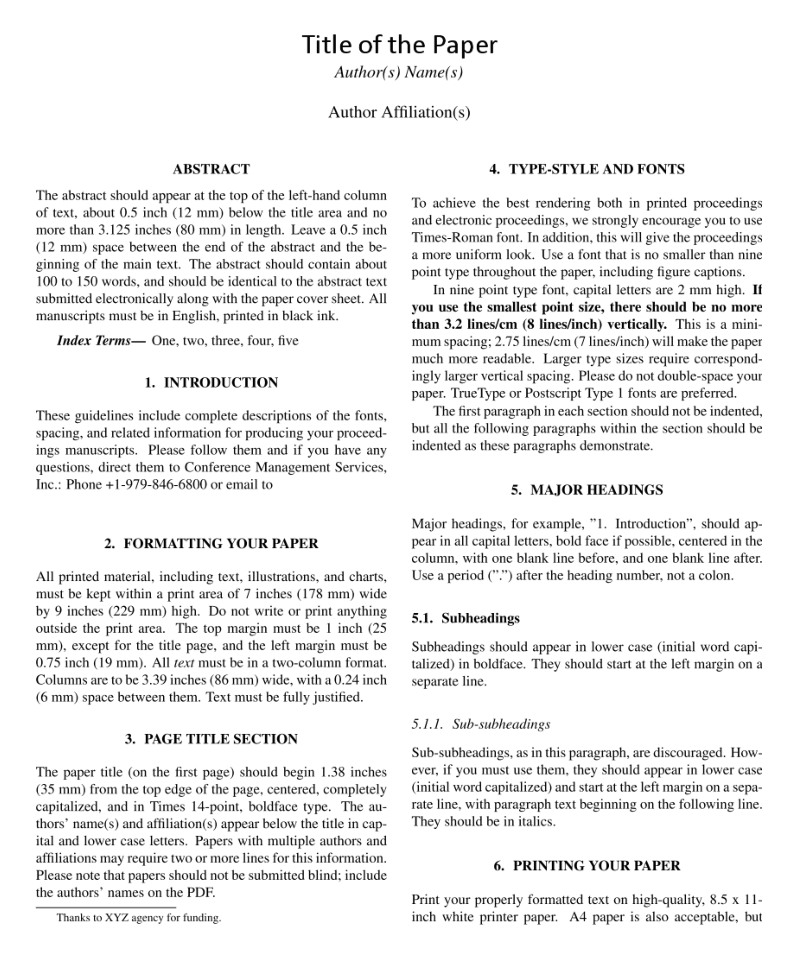

In [2]:
img_name = "./X7Ztx.png"
img = cv2.imread(img_name, 0)
img = img[20:-20, 20:-20]

# Non-local means denoising
img = cv2.fastNlMeansDenoising(img)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

### We have applied Otsu thresholding. This binarizes the image. We removed any skewness present in the document. CCL is applied after that. It gives us number of labels, labels, Statistics and centroids.

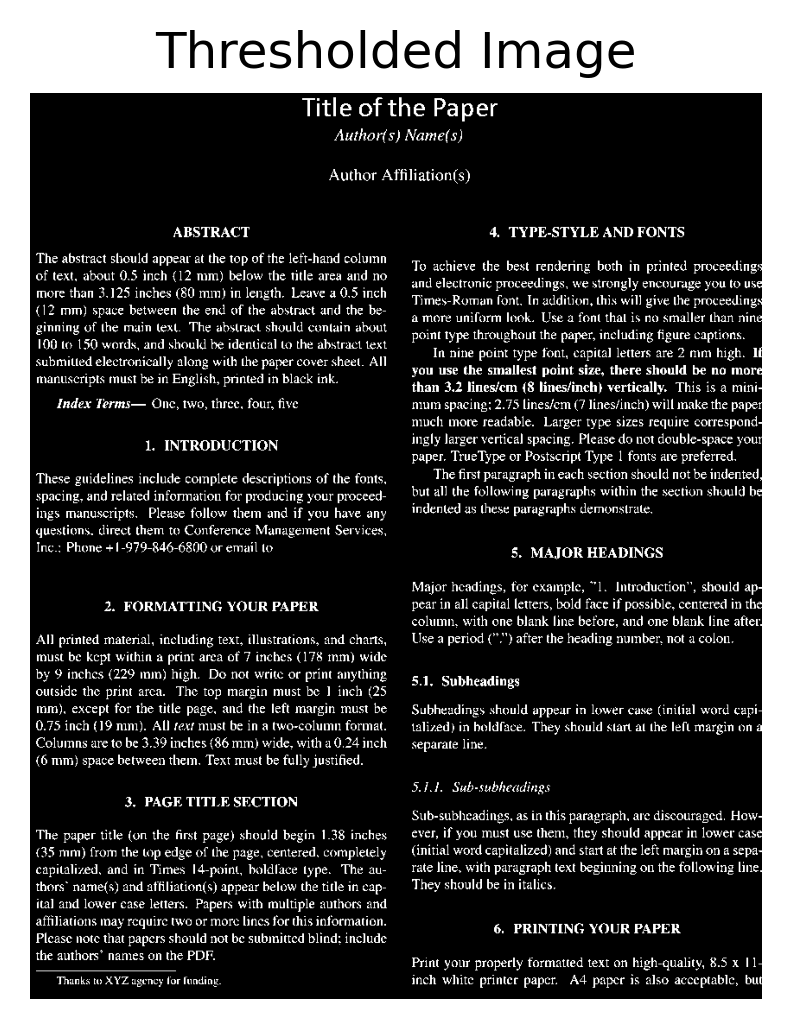

In [3]:
# thresholding
_, thresh_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(thresh_img, cmap="gray")
plt.title("Thresholded Image")
plt.axis("off")
plt.show()

# Skew correction
lines = cv2.HoughLines(thresh_img, 1, np.pi / 180, 200)
t = []
for i in range(lines.shape[0]):
    t.append(lines[i][0][1])
ang = int(round(180 * np.median(t) / 3.14))

# referred from OpenCV documentation
(h, w) = thresh_img.shape
(cX, cY) = (w // 2, h // 2)
M = cv2.getRotationMatrix2D((cX, cY), int((180 * np.median(t) / 3.14) - 90), 1.0)
thresh_img = cv2.warpAffine(thresh_img, M, (w, h))

# Connected components labeling
output = cv2.connectedComponentsWithStats(thresh_img, 8, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output

### We have applied DBSCAN for clustering.

In [4]:
# pipeline
pipe = Pipeline(
    [
        ("scaler", StandardScaler(with_std=False)),
        ("cluster", DBSCAN(min_samples=5, eps=20)),
    ]
)

prediction = pipe.fit_predict(centroids[1:, :])

### Clusters were differently colored in this block for better visualisation.

  0%|          | 0/3698 [00:00<?, ?it/s]

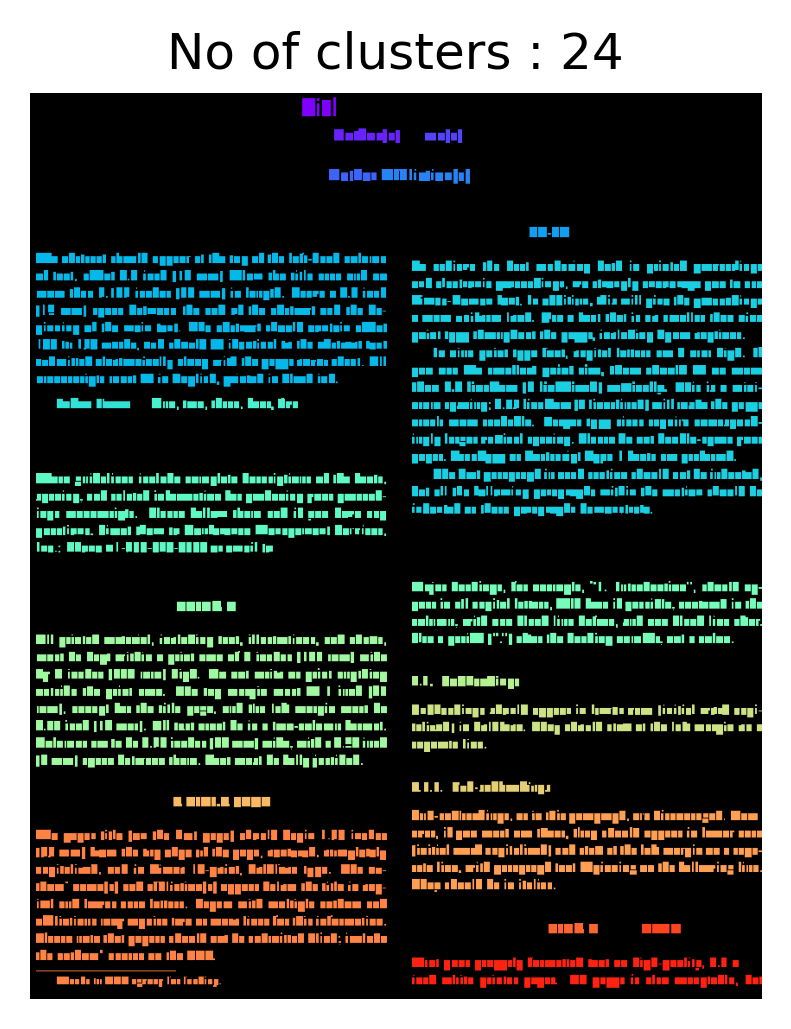

True

In [5]:
ccl_img = np.zeros((img.shape[0], img.shape[1], 3), dtype="uint8")
cluster_img = ccl_img.copy()
ccl_img[labels > 0] = 255
indexes = centroids.astype(int)

# coloring the different blocks to show clustering by DBSCAN
color = np.uint8(
    cm.rainbow(np.linspace(0, 1, len(np.unique(pipe["cluster"].labels_))))[:, :-1] * 255
)

rects = []

# We formed the bounding boxes here.
for i in tqdm(range(1, numLabels)):
    l = np.uint8(np.where(labels == i, 1, 0))
    x, y, w, h = cv2.boundingRect(l)
    rects.append((x, y, w, h))

    if prediction[i - 1] != -1:
        cluster_img[y : y + h, x : x + w] = color[prediction[i - 1]]

    # plotting ccl
    ccl_img = cv2.rectangle(ccl_img, (x, y), (x + w, y + h), (36, 255, 12), 1)

plt.imshow(cluster_img)
plt.title(f"No of clusters : {len(np.unique(pipe['cluster'].labels_))}")
plt.axis("off")
plt.savefig("clusters.png", transparent=False, bbox_inches="tight", facecolor="white")
plt.show()
plt.close()

cv2.imwrite("ccl_img.png", ccl_img)

### We made x and y coordinates. H and W are heights and widths. Dataframes are easier to work through the clusters.

In [6]:
# Made a DataFrame with x, y coordinates.
df = pd.DataFrame(rects, columns=["X", "Y", "H", "W"])
df["Cluster"] = pipe["cluster"].labels_
df.head()

,X,Y,H,W,Cluster
0,351,5,3,22,0
1,397,5,11,22,-1
2,427,5,13,22,-1
3,315,6,15,21,0
4,332,6,3,3,0


### We formed the bounding boxes here.

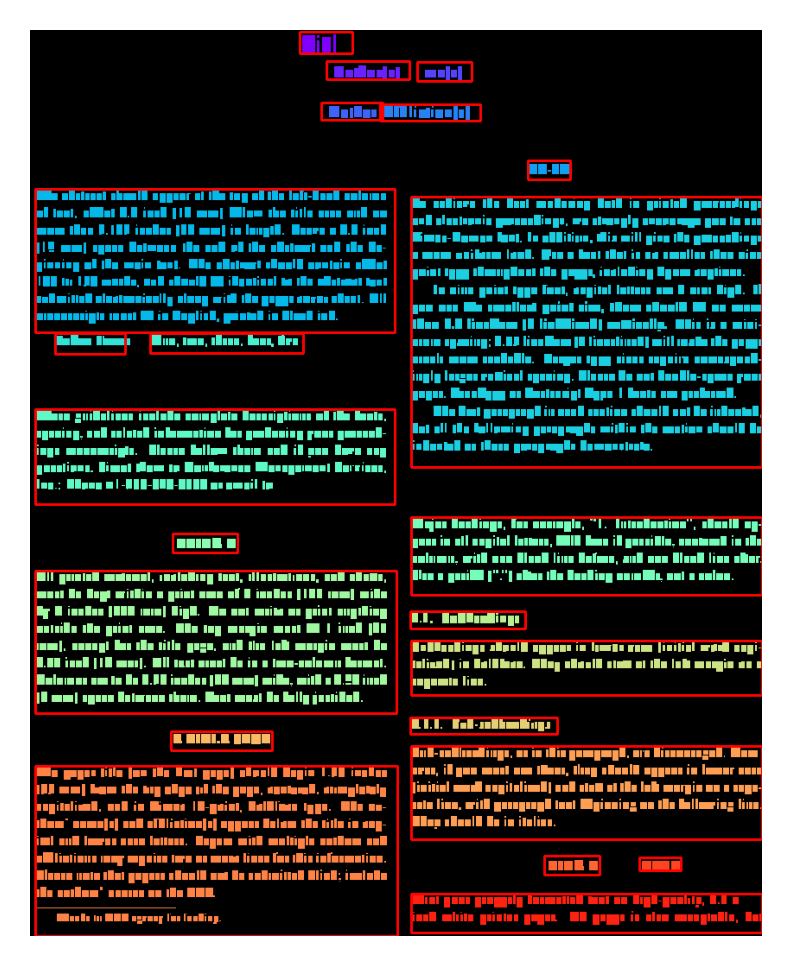

In [7]:
cluster_rects = []
cluster_img1 = cluster_img.copy()

for i in np.unique(pipe["cluster"].labels_):
    if i != -1:
        dftemp = df[df["Cluster"] == i]

        x1opt = max(dftemp.X.min() - dftemp.W.min(), 0)
        y1opt = max(dftemp.Y.min() - dftemp.H.min(), 0)
        x2opt = min(dftemp.X.max() + dftemp.W.max(), img.shape[1])
        y2opt = min(dftemp.Y.max() + dftemp.H.max(), img.shape[0])
        cluster_rects.append((x1opt, y1opt, x2opt, y2opt))

        cluster_img1 = cv2.rectangle(
            cluster_img1, (x1opt, y1opt), (x2opt, y2opt), (255, 0, 0), 2
        )

plt.imshow(cluster_img1)
plt.axis("off")
plt.show()

### HTML document is finally made in this block.

In [8]:
import dominate
import pytesseract
from PIL import Image
import dominate.tags as ts

doc = dominate.document(title="Result")

width, height = img.shape[1], img.shape[0]
fontSize = df.H.mean()

with doc.head:
    ts.script(
        """
        window.onload = function() {
            window.print();
        };
    """,
        type="text/javascript",
    )

    ts.style(
        f"""
        body {{
             background-color: white;
             color: black;
             font-family: sans-serif;
             font-size: {fontSize}px;
             width: {width}px
             height: {height}px
         }}
        html, body {{
            width: 100%;
            height: 100%;
            min-height: 100vh;
        }}
     """
    )


for x1, y1, x2, y2 in tqdm(cluster_rects):
    _im = img[y1:y2, x1:x2]
    if _im.size == 0:
        continue
    text = pytesseract.image_to_string(Image.fromarray(_im))
    text = text.replace("\n", " ")
    with doc:
        with ts.p(text):
            ts.attr(
                style=f"width: {x2-x1}px; height: {y2-y1}px; left: {x1}px; top: {y1}px; position: absolute;"
            )

with open("result.html", "w") as h:
    h.write(doc.render(pretty=True))

  0%|          | 0/23 [00:00<?, ?it/s]

### Open result.html in a new tab.